# Bayesian Linear Model

<br><li>So to solve the linear models, we need to find the parameters $W$, and we have <b>two main approaches</b>:
<ul>
    <li><h3>1) The frequentist approaches:</h3><br> <ul><li>In which we seek to estimate the parameters $W$ that maximize or minimize some criterion:</li><br>
    <ul>
        <li><b>1) Maximum Likelihood Estimation (MLE):</b><br>
            <ul>
                <p>$$*\;W_{MLE} = (\Phi^T\Phi)^{-1}\Phi^T Y\\
    *\;\frac{1}{\beta_{MLE}}=\frac{1}{N}\{W^T\Phi(X) - y_{n}\}^2$$</p><br>
                <li>$P(D|W)$, we consider distribution over $D$(fixed) parametrized by $W$
                <li>So, we are optimizing over a function of $W$, and $D$ is fixed.
                <li>Suffers from over-fitting.
            </ul><br>
        <li><b>2) Maximum A Posterior Estimation (MAPE):</b><br>
            <ul>
                <p>$$*\;W_{MAP}=(\Phi^T\Phi + \lambda I)^{-1}\Phi^T Y\\
    *\;\frac{1}{\beta_{MAPE}}=\frac{1}{N}\{W^T\Phi(X) - y_{n}\}^2$$</p><br>
                <li>$P(W|D)$, a probability distribution over $W$, so we change the point of view.
                <li>So, we assume that $y$ and $W$ a r.vs
            </ul>
        </ul></ul><br>
        
<li><h3>2) The bayesian approach: </h3><br><li>Instead of finding $W$ that maximize or minimize some criterion, we're dealing with $W$ as a r.v and then compute a full posterior over it.</li><br>
    <ul>
        <li>We have the following:
            <ul>
                <li><b>Likelihood:</b> $P(y|X, W, \beta) = N(y|W^T\Phi(X)\beta^{-1})$</li><br>
                <li><b>Conjugate prior:</b> $P(W) = N(W|m_{0}, S_{0})$</li><br>
                <li><b>Posterior:</b> $P(W|y) = \frac{P(y|X, W, \beta) P(W)}{P(y|x)}$, where $P(X|Y) = \int P(y|X, W) P(W) dW = \mathbb{E}_{W}[P(y|X, W)] "The\;marginal\;likelihood"$
        </ul><br>
        <li>After some calulation and completing square, the posterior is given by:</li><br>
        <ul><p>$P(W|X, y) = N(W| m_{N}, S_{N})$, Where:<ul><br>$\\1)\;S_{N} = (S_{0}^{-1} + \beta\;\Phi^{T}\Phi)^{-1}$<br>
            <p>$2)\;m_{N} = S_{N}(S_{0}^{-1}m_{0} + \beta\;\Phi^{T}y)^{-1}$</ul>
        </ul><br>
    <li>Now we have the posterior, and to make a prediction, we need to compute the posterior prediction. And this will tell us the region where the prediction lies.
        <ul><p>$$P(y_{i}|Y, X, \beta) = \int P(y_{i}|x_{i}, W, \beta) P(W|X, Y, \beta) dW\\
                = N(y_{i}|\Phi(x_{i})^TW, \beta^{-1}) N(W|m_{N}, S_{N})\\
                = N(y_{i}|m_{N}^T\phi(x_{i}), \phi(x_{i})^TS_{N}\phi(x_{i}))$$<br>
            </ul>
    </ul>
    
<li>If $\beta$ is unkown, the conjugate prior will be Normal-Gamma not Normal.
<li>But for simplicity, I'll assume $\beta$ is known.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import warnings

warnings.filterwarnings("ignore")

#### Generate the data

In [2]:
def simulator(f, sample_size, std, l=0, h=1):
    x = np.linspace(l, h, sample_size)
    noise = np.random.normal(scale=std, size=x.shape)
    t = f(x) + noise
    return x.reshape(sample_size, -1), t

def f(x):
    return np.sin(2 * np.pi * x)

# generate data
def genrate_data(N_tr=10, N_ts=100, std=0.3, l=0, h=1):
    x_train, y_train = simulator(f, N_tr, std, l=l, h=h)
    x_test = np.linspace(l, h, N_ts)
    y_test = f(x_test)
    return x_train.reshape(N_tr, -1), y_train, x_test.reshape(N_ts, -1), y_test

### [Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

In [3]:
class Bayesian:
    def __init__(self, basis, beta:float=1.5, alpha:float=1.2, degree=None, b_mu=None, b_s=None):
        self.alpha = alpha
        self.beta = beta
        self.basis = basis
        self.degree = degree
        self.b_mu = b_mu
        self.b_s = b_s
        self.m_N = None
        self.S_N = None
        
    # get the basis of the input (Gaussian, Poly, Sigmoidal)
    def _basis(self, X):
        if isinstance(self.b_mu, int):
            self.b_mu = [self.b_mu] 
            
        X_trans = []
        if self.basis.lower()=='gauss':
            for m in self.b_mu:
                X_trans.append(np.exp(-0.5 * np.square(X - m)/self.b_s))

        elif self.basis.lower()=='poly':
            for i in range(0, self.degree+1):
                X_trans.append(X**i)

        elif self.basis.lower()=='sig':
            for m in self.b_mu:
                X_trans.append((np.tanh((X - m) / self.b_s) + 1 ) / 2)
        else:
            raise "Only Gauss, Poly, Sig"

        return np.asarray(X_trans).squeeze().transpose()

    # get a uninformative prior
    def get_prior(self, m):
        S_0 = np.eye(m) * self.alpha
        m_0 = np.zeros((m, 1))
        return S_0, m_0
        
    # fit the data to get the m_N and S_N of the posterior
    def fit(self, X, y):
        
        if self.basis:
            X = self._basis(X)
        
        self.N, self.P = X.shape
        
        # add cloumn of ones in X for the bias term
        X = np.append(X, np.ones((self.N, 1)), axis=1)
        y = y.reshape(self.N, 1)
        
        #################
        # Get the prior #
        #################
        self.S_0, self.m_0 = self.get_prior(self.P + 1)
        
        #############################
        # calculating the posterior #
        #############################
        # S_N = (S_0^-1 + B phi.T phi)^-1
        self.S_N = np.linalg.inv(np.linalg.inv(self.S_0) + self.beta * X.T.dot(X))
        self.m_N = self.S_N.dot(np.linalg.inv(self.S_0).dot(self.m_0) + self.beta * X.T.dot(y))  
        # The posterior
        self.posterior = multivariate_normal(mean=self.m_N.ravel(), cov=self.S_N)

        
    # get the posterior predictive
    def posterior_predictive(self, X, std=False):

        if self.basis:
            X = self._basis(X)
        
        X = X.reshape(-1, self.P)
        X = np.append(X, np.ones((X.shape[0],1)), axis=1)
        
        self.P_M = X.dot(self.m_N).ravel()
        self.P_S = np.array(list(map(lambda x: x.dot(self.S_N).dot(x.T) + self.beta, X))) # X.dot(self.S_N).dot(X.T)
        post_pred = multivariate_normal(mean=self.P_M.ravel(), cov=self.P_S)
        return post_pred

    def predict(self, X, samples=1, std=False):
        X = np.append(self._basis(X), np.ones((X.shape[0], 1)), axis=1)        
        W_samples = self.posterior.rvs(samples)
        preds = W_samples.T @ X.T
        self.pred_std = np.sqrt(1/self.beta + np.sum(X.dot(self.S_N).dot(X.T), axis=1))
        return preds

In [4]:
N=25                           # training data size
degree=10                      # poly degree or number of basis (Gaussian or Sigmoidal)
Beta=100.0                     # Assume data noise precision is known
alpha=10.0                     # Assume prior precision is known
mu=np.linspace(1, 0, degree)   # Basis mean
s = 0.05                       # Basis std
X_train, y_train, X_test, y_test = genrate_data(N_tr=N, l=0, h=1, std=0.2) # generate data

In [5]:
model = Bayesian(basis='Gauss', degree=degree, b_mu=mu, b_s=s, beta=Beta, alpha=alpha)
model.fit(X_train, y_train)

In [6]:
# get the posterior distribution
posterior = model.posterior

> #### <li> Now to make prediction, we can sample from the posterior and compute the prediction (W.T @ X).<br> <li> Also, for each sample, we can make a sample from the posterior predictive to get the uncertainty over the prediction. 

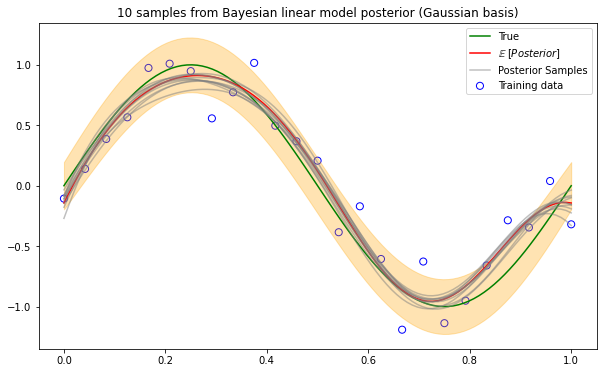

In [7]:
plt.figure(figsize=(10, 6))
plt.title('10 samples from Bayesian linear model posterior (Gaussian basis)')
plt.plot(X_test, y_test, 'green', label='True')
plt.scatter(X_train, y_train, label='Training data', alpha=1, facecolor="none", edgecolor='b', s=50)
exp_post = posterior.mean @ np.append(model._basis(X_test), np.ones((100, 1)), axis=1).T
plt.plot(X_test, exp_post, 'r', label='$\mathbb{E}\;[Posterior]$')
for i in range(10):
    pred = model.predict(X_test, 1)
    plt.plot(X_test, pred, c='gray', alpha=0.5, label='Posterior Samples' if i==0 else None)
plt.fill_between(X_test.flatten(), y_test - model.pred_std, y_test + model.pred_std, color='orange', alpha=0.3)
plt.legend();

><b> So, in Bayesian linear regression, instead of doing a point estimate for the parameters (as in MLE and MAPE), it models the entire data set to create a distribution over the parameters, allowing us to sample from that distribution to obtain sample linear regression lines.

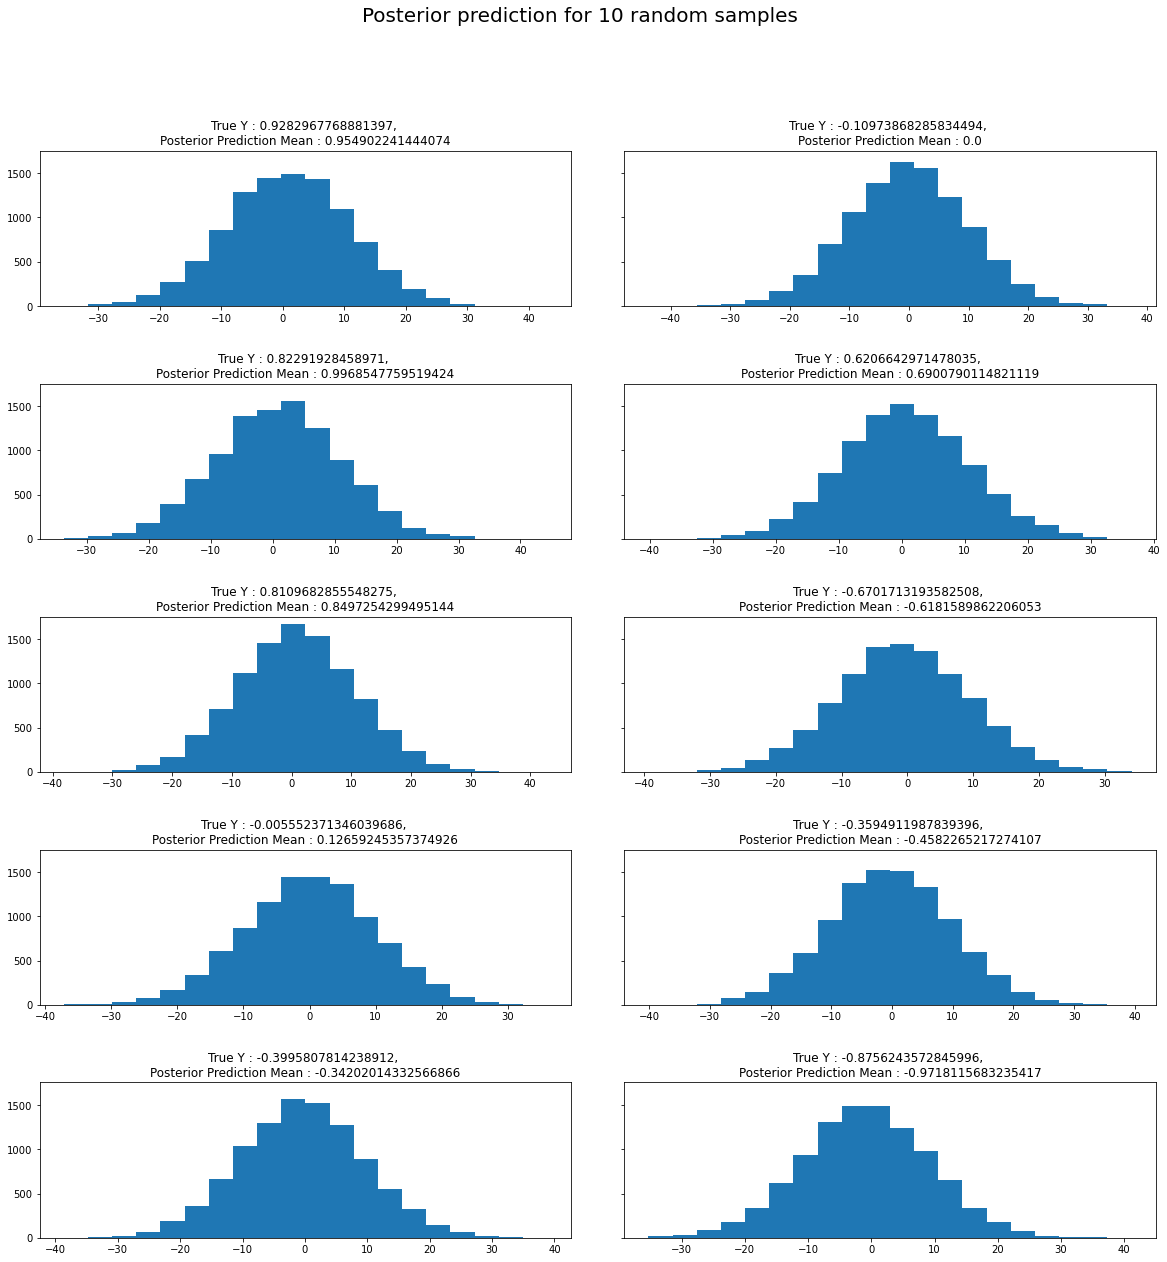

In [8]:
# example for sampling from the posterior prediction

fig, axes = plt.subplots(5, 2, figsize=(20, 20), sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.1})
fig.suptitle('Posterior prediction for 10 random samples', fontsize=20)

for i in range(10):
    # random sample from the test data
    idx = min(np.random.choice(range(len(y_test)), 1), len(y_test))[0]
    # get the posterior prediction of the random sample
    post_pred = model.posterior_predictive(X_test[idx:idx+1])
    # sample from the posterior prediction
    samples = post_pred.rvs(10000)
    # plot the results
    axes[i//2][i%2].set_title('True Y : {}, \nPosterior Prediction Mean : {}'.format(np.mean(samples), y_test[idx]))
    axes[i//2][i%2].hist(samples, bins=20);